# **Reinforcement Learning**

## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
其餘套件則是為了在 Colab Notebook 中使用 gym、繪圖等所需要的套件。

In [1]:
!apt update
!apt install xvfb python-opengl -y
!pip install gym[box2d] pyvirtualdisplay

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/

首先，引入運算及建構神經網路的套件：

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

為了使 gym 能在 Colab Notebook 中運作需要設置 virtual display，引入套件並開啟 virtual display：

In [3]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start();

引入繪圖、製作和播放動畫分別所需的套件：

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

最後，引入 OpenAI 的 gym：

In [5]:
import gym

等一下在 gym 當中遊玩時，這過程我們將其製作成動畫，再循環播放出來。

In [6]:
def turn_frames_into_animation(frames):
    """Convert image frames into animation."""
    fig = plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=40, repeat=False)
    plt.close(fig)
    return anim

## 什麼是 Lunar Lander？

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

所謂的「環境」其實同時包括了 agent 和 environment。
我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（在 LunarLander-v2 這個環境中，這兩個名詞代表同樣的意思）和 reward。

在下方所有操作以先，建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

In [7]:
env = gym.make('LunarLander-v2')

### Observation / State

我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [8]:
print(env.observation_space)

Box(8,)


`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等。

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [9]:
print(env.action_space)

Discrete(4)


`Discrete(4)` 說明 agent 可以採取四種離散的行動：
- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

接下來，我們嘗試讓 agent 與 environment 互動。
在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。
而這個函式同時會回傳「環境」最初始的狀態。

In [11]:
initial_state = env.reset()
print(initial_state)

[ 0.00480595  1.4053375   0.4867781  -0.24812394 -0.00556214 -0.11026248
  0.          0.        ]


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [12]:
random_action = env.action_space.sample()
print(random_action)

0


再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。
而這個函式會回傳四項資訊：
- observation / state
- reward
- 完成與否
- 其餘資訊

In [13]:
state, reward, done, info = env.step(random_action)

第一項資訊 `state` 即為 agent 採取行動之後，agent 觀察環境的 observation 或者說整個環境的 state 為何。
而第三項資訊 `done` 則是 `True` 或 `False` 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 `step()` 函式便會回傳 `done = True`，而在那之前，`done` 則保持 `False`。

In [14]:
print(done)

False


### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
> If lander moves away from landing pad it loses reward back.
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
> Each leg ground contact is +10.
> Firing main engine is -0.3 points each frame.
> Solved is 200 points.

In [15]:
print(reward)

-1.0858734941686805


### Random Agent

最後，在進入實做之前，我們來看看一個新手 agent 能否成功登陸月球。
這個 agent 不會考慮當前的情況（observation/state）為何，只會隨機採取行動，從四種可能當中隨便做一個動作。

在 agent 的遊玩過程中，我們將遊戲畫面記錄下來，做成動畫。

In [16]:
env.reset()

frames = []

while True:
    frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)

    if done:
        anim = turn_frames_into_animation(frames)
        break

然後將剛剛 agent 的遊玩畫面播放出來：

In [17]:
HTML(anim.to_html5_video())

## Policy Gradient

現在來搭建一個簡單的 agent，其中包括一個 policy network：
- 輸入是 8-dim 的 observation
- 輸出是離散的四個動作之一

而這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [18]:
class Agent():

    def __init__(self):
        self.network = nn.Sequential(
            nn.Linear(8, 32),
            nn.Tanh(),
            nn.Linear(32, 4),
            nn.Softmax(dim=-1)
        )
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        """Learn from recorded log probabilities and rewards."""
        loss = (-log_probs * rewards).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        """Sample an action from the network according to the given state."""
        action_prob = self.network(torch.FloatTensor(state))
        action_distribution = Categorical(action_prob)
        action = action_distribution.sample()
        log_prob = action_distribution.log_prob(action)
        return action.item(), log_prob

最後，建立一個 agent，就可以開始進行訓練了。

In [19]:
agent = Agent()

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [20]:
agent.network.train()  # 訓練前，先確保 network 處在 training 模式

avg_total_rewards, avg_final_rewards, avg_total_steps = [], [], []

for batch in range(777):

    log_probs, rewards = [], []                             # 存放訓練資料
    total_rewards, final_rewards, total_steps = [], [], []  # 存放訓練過程

    ## 蒐集訓練資料
    for episode in range(3):
        
        state = env.reset()
        total_reward, total_step = 0, 0

        while True:

            action, log_prob = agent.sample(state)
            log_probs.append(log_prob)

            state, reward, done, _ = env.step(action)

            total_reward += reward
            total_step += 1

            if not done and total_step >= 500:
                reward = 0  # the lander is neither crashed nor still
                done = True

            if done:
                total_rewards.append(total_reward)
                final_rewards.append(reward)
                total_steps.append(total_step)
                rewards.append(np.full(total_step, total_reward))  # 設定同一個 episode 每個 action 的 reward 都是 total reward
                break

    ## 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_step = sum(total_steps) // len(total_steps)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    avg_total_steps.append(avg_total_step)
    print(f"Batch {batch+1:4d}, "
          f"total reward: {avg_total_reward: 6.1f}, "
          f"final reward: {avg_final_reward: 6.1f}, "
          f"total step: {avg_total_step:4d}")

    ## 更新網路
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

Batch    1, total reward: -314.0, final reward: -100.0, total step:   84
Batch    2, total reward: -178.0, final reward: -100.0, total step:   86
Batch    3, total reward: -137.7, final reward: -100.0, total step:   98
Batch    4, total reward: -315.8, final reward: -100.0, total step:   99
Batch    5, total reward: -127.7, final reward: -100.0, total step:   72
Batch    6, total reward: -110.1, final reward: -100.0, total step:   88
Batch    7, total reward: -143.9, final reward: -100.0, total step:   61
Batch    8, total reward: -195.6, final reward: -100.0, total step:   87
Batch    9, total reward: -116.5, final reward: -100.0, total step:   77
Batch   10, total reward: -166.3, final reward: -100.0, total step:   70
Batch   11, total reward: -142.3, final reward: -100.0, total step:   93
Batch   12, total reward: -167.5, final reward: -100.0, total step:   83
Batch   13, total reward: -206.9, final reward: -100.0, total step:   90
Batch   14, total reward: -123.6, final reward: -10

### 訓練結果

先設計一個函式來畫出剛剛的訓練過程：

In [21]:
def plot_values_with_title(values, title):
    plt.plot(values)
    plt.title(title)
    plt.show()
    plt.close()

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

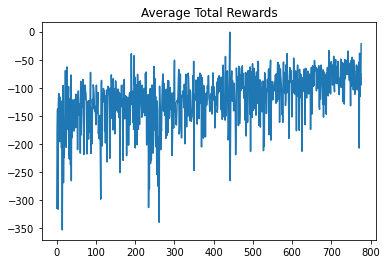

In [22]:
plot_values_with_title(avg_total_rewards, "Average Total Rewards")

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

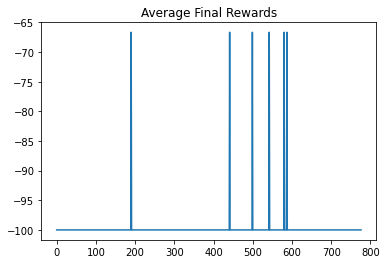

In [23]:
plot_values_with_title(avg_final_rewards, "Average Final Rewards")

最後是 `avg_total_step`，訓練的初期，小艇會慢慢地學會要向下噴火，以免墜毀而受到懲罰。
因此，觀察這個數值也可以在訓練前期看出 agent 是否開始學會如何避免墜毀。

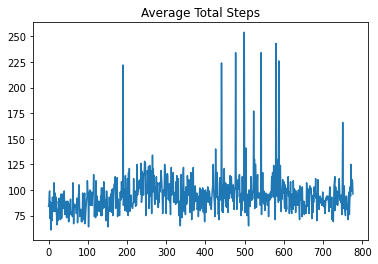

In [24]:
plot_values_with_title(avg_total_steps, "Average Total Steps")

## 測試

接下來進入測試階段，我們讓 agent 連續玩多個回合的遊戲，並且將成績最好的那個回合儲存下來。

In [25]:
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

best_total_reward = float('-inf')

for i in range(20):

    state = env.reset()
    total_reward = 0
    frames = []

    while True:
        frames.append(env.render(mode='rgb_array'))
        
        action, _ = agent.sample(state)
        state, reward, done, _ = env.step(action)

        total_reward += reward

        if done:
            print(f"episode {i+1:3d}, total_reward = {total_reward:.1f}")
            break

    if total_reward > best_total_reward:
        best_total_reward = total_reward
        anim = turn_frames_into_animation(frames)

episode   1, total_reward = -44.6
episode   2, total_reward = -98.4
episode   3, total_reward = -109.9
episode   4, total_reward = -80.3
episode   5, total_reward = -151.6
episode   6, total_reward = -79.2
episode   7, total_reward = -76.3
episode   8, total_reward = -72.2
episode   9, total_reward = -224.5
episode  10, total_reward = -47.5
episode  11, total_reward = -7.9
episode  12, total_reward = -196.9
episode  13, total_reward = -92.9
episode  14, total_reward = -98.0
episode  15, total_reward = -87.2
episode  16, total_reward = -47.9
episode  17, total_reward = -58.4
episode  18, total_reward = -38.9
episode  19, total_reward = -110.0
episode  20, total_reward = -4.1


現在，把最高分的那場遊戲影片播出來：

In [26]:
HTML(anim.to_html5_video())

接下來，這邊有一個事先訓練好的 agent，我們可以來看看這個 agent 是不是更厲害一些。訓練用的程式碼位於：[yistLin/lunar-lander](https://github.com/yistLin/lunar-lander)

首先，下載訓練好的模型到當前的環境中：

In [27]:
!wget https://github.com/yistLin/lunar-lander/raw/master/checkpoints/agent2.pth

--2020-08-12 12:51:42--  https://github.com/yistLin/lunar-lander/raw/master/checkpoints/agent2.pth
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yistLin/lunar-lander/master/checkpoints/agent2.pth [following]
--2020-08-12 12:51:42--  https://raw.githubusercontent.com/yistLin/lunar-lander/master/checkpoints/agent2.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13541 (13K) [application/octet-stream]
Saving to: ‘agent2.pth’

agent2.pth          100%[===================>]  13.22K  --.-KB/s    in 0.003s  

2020-08-12 12:51:43 (3.89 MB/s) - ‘agent2.pth’ saved [13541/13541]



定義新的 agent 該長什麼樣子。
這個 agent 的 network 的層數更多也更寬，相較於先前那個 agent，這個更「肥」一些。

In [28]:
class FatAgent():

    def __init__(self):
        self.network = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.Softmax(dim=-1)
        )

    def sample(self, state):
        """Sample an action from the network according to the given state."""
        action_prob = self.network(torch.FloatTensor(state))
        action_distribution = Categorical(action_prob)
        action = action_distribution.sample()
        return action.item()

建立新的 agent，並且使用之前預先訓練好的模型。

In [31]:
agent2 = FatAgent()
state_dict = torch.load("agent2.pth", map_location="cpu")
agent2.network.load_state_dict(state_dict)

<All keys matched successfully>

測試看看它的表現是否更加出色：

In [32]:
agent2.network.eval()

best_total_reward = float('-inf')

for i in range(5):

    state = env.reset()
    total_reward = 0
    frames = []

    while True:
        frames.append(env.render(mode='rgb_array'))
        
        action = agent2.sample(state)
        state, reward, done, _ = env.step(action)

        total_reward += reward

        if done:
            print(f"episode {i+1:3d}, total_reward = {total_reward:.1f}")
            break

    if total_reward > best_total_reward:
        best_total_reward = total_reward
        anim = turn_frames_into_animation(frames)

episode   1, total_reward = 17.0
episode   2, total_reward = 25.0
episode   3, total_reward = 240.1
episode   4, total_reward = 282.3
episode   5, total_reward = 298.0


最後，再將最好的結果播放出來。

In [33]:
HTML(anim.to_html5_video())

## 參考資料

以下是一些有用的參考資料。
建議同學們可以先參考第一則連結的上課影片，在影片的最後有提到兩個有用的 Tips，對於理解及嘗試本次實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
